In [292]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Load Data

## Product

In [293]:
product = pd.read_csv('product.csv', dtype={"CLNT_ID":np.str, "SESS_ID":np.str},thousands=","
                     ,usecols = [0,1,2,3,5,6,7])
product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,07605037,12,642112,[바비브라운],39000,1
1,4140076,10189797,13,570603,데상트,39000,2
2,4142395,06158159,85,179538,[아베다],39000,1
3,4144914,07935714,12,554336,아디다스 키즈,39000,1
4,4144917,06406509,78,190306,데코르테,39000,5


In [313]:
#괄호 없애기
def remove_parenthesis(brand_name):
        for i in range(len(brand_name)) :
           if '(' in brand_name[i] :
               start = brand_name[i].find('(')
               end = brand_name[i].find(')')
               brand_name[i] = brand_name[i][:start] + brand_name[i][end+1:]

remove_parenthesis(product['PD_BRA_NM'])

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [302]:
#브랜드명 대괄호 삭제
product['PD_BRA_NM'] = product['PD_BRA_NM'].map(lambda row: row.replace('[', ''))
product['PD_BRA_NM'] = product['PD_BRA_NM'].map(lambda row: row.replace(']', ''))

In [305]:
#product[product['CLNT_ID']=='0000014']

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
4386392,0000014,01156991,284,645262,로이드(주얼리),29900,1
5015932,0000014,01156991,284,369141,로이드,39900,1


In [303]:
#고객별 구매 브랜드 종류 수
product.groupby(['CLNT_ID']).nunique()['PD_BRA_NM']

CLNT_ID
0000008     1
0000014     2
0000025     2
0000032     3
0000033     4
0000051     1
0000056     2
0000058     3
0000059     1
0000063     6
0000064     1
0000068     5
0000071     3
0000073     2
0000078     1
0000080     3
0000089     1
0000093     1
0000100     2
0000104     1
0000106     1
0000114     1
0000121     2
0000129     2
0000135     5
0000136     2
0000148     1
0000149     1
0000156     6
0000159     4
           ..
6592400     2
6592402     3
6592405    11
6592406     2
6592408     1
6592410     1
6592435     1
6592442     4
6592452     1
6592454     3
6592461     2
6592462     1
6592470     1
6592475     5
6592479     1
6592481     1
6592482     1
6592485     2
6592488     2
6592502     1
6592503     3
6592506     4
6592519     2
6592524     5
6592536     4
6592537     2
6592544     1
6592551     2
6592553     7
6592554     4
Name: PD_BRA_NM, Length: 922737, dtype: int64

## Customer

In [294]:
custom = pd.read_csv('custom.csv', dtype={"CLNT_ID":np.str})
custom.head()

,CLNT_ID,CLNT_GENDER,CLNT_AGE
0,4830726,F,30
1,4830874,F,40
2,4830975,F,30
3,4831275,F,30
4,4825325,F,30


## Session

In [295]:
session = pd.read_csv('new_session.csv', dtype={"CLNT_ID":np.str, "SESS_ID":np.str},thousands=",")
session.head()

,CLNT_ID,SESS_ID,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,weekday,weekday/weekend
0,5873599,08641867,9,20180509,82.0,1890.0,mobile,Daejeon,Daejeon,Wednesday,weekday
1,5873599,06616320,21,20180611,105.0,1604.0,mobile,Busan,Busan,Monday,weekday
2,5873599,05886172,40,20180624,41.0,632.0,mobile,Daejeon,Daejeon,Sunday,weekend
3,5873884,01050889,15,20180913,160.0,1035.0,mobile,Gyeonggi-do,Anyang,Thursday,weekday
4,5874461,10298270,5,20180412,13.0,298.0,mobile,Seoul,Seoul,Thursday,weekday


In [296]:
d1=session.loc[session['ZON_NM']=='Gyeonggi-do']

In [297]:
# month columns
session['SESS_DT'] = pd.to_datetime(session['SESS_DT'], format="%Y%m%d")
session['SESS_month'] = pd.DatetimeIndex(session['SESS_DT']).month

## Master

In [298]:
master = pd.read_csv('new_Master.csv',
                     usecols=[0,5])
master.head()

,PD_C,CLAC0_NM
0,64382,스포츠/레저
1,62282,패션의류
2,61729,유아동
3,61537,패션의류
4,58820,패션의류


In [299]:
labels, uniques = pd.factorize(master['CLAC0_NM'],sort=True)
print(uniques)

Index(['가구/침구/인테리어', '가전/디지털', '반려동물', '스포츠/레저', '식품', '여행/서비스/금융', '유아동',
       '주방/생활/건강', '패션의류', '화장품/뷰티'],
      dtype='object')


# Merge datasets

In [300]:
m0 = pd.merge(product, custom, on='CLNT_ID', how = 'inner')
m00 = pd.merge(m0, master, on=['PD_C'], how = 'inner')
m1 = pd.merge(m00, session, on=['CLNT_ID','SESS_ID'], how = 'inner')
m0.shape,m00.shape,m1.shape

((3988587, 9), (3988587, 10), (3988587, 20))

In [301]:
m1.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,CLNT_GENDER,CLNT_AGE,CLAC0_NM,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,weekday,weekday/weekend,SESS_month
0,4140076,10189797,13,570603,데상트,39000,2,F,40,스포츠/레저,172,2018-04-13,18.0,113.0,mobile,Gyeonggi-do,Icheon-si,Friday,weekday,4
1,4140076,10189797,13,411029,아디다스(의류),29000,1,F,40,스포츠/레저,172,2018-04-13,18.0,113.0,mobile,Gyeonggi-do,Icheon-si,Friday,weekday,4
2,4148106,06537318,21,570603,데상트,39000,1,F,30,스포츠/레저,58,2018-06-13,20.0,144.0,mobile,Gwangju,Gwangju,Wednesday,weekend,6
3,4148106,06662803,94,570603,데상트,39000,1,F,30,스포츠/레저,55,2018-06-11,93.0,1371.0,mobile,Seoul,Seoul,Monday,weekday,6
4,4148106,06662803,94,529438,라코스테(의류),88000,1,F,30,패션의류,55,2018-06-11,93.0,1371.0,mobile,Seoul,Seoul,Monday,weekday,6


# 파생변수

In [334]:
#페이지 뷰당 머문 세션 시간
m1['SESSHR_dividedby_VIEW']=m1['TOT_SESS_HR_V']/m1['TOT_PAG_VIEW_CT']

In [336]:
#구매 한번 당 결제 금액
m1['AM_dividedby_CT']=m1['PD_BUY_AM']/m1['PD_BUY_CT']

# Split by class

In [11]:
#'가구/침구/인테리어', '가전/디지털', '반려동물', '스포츠/레저', '식품', '여행/서비스/금융', '유아동', 
# '주방/생활/건강', '패션의류', '화장품/뷰티'
class1=m1.loc[m1['CLAC0_NM']=='가구/침구/인테리어']
class2=m1.loc[m1['CLAC0_NM']=='가전/디지털']
class3=m1.loc[m1['CLAC0_NM']=='반려동물']
class4=m1.loc[m1['CLAC0_NM']=='스포츠/레저']
class5=m1.loc[m1['CLAC0_NM']=='식품']
class6=m1.loc[m1['CLAC0_NM']=='여행/서비스/금융']
class7=m1.loc[m1['CLAC0_NM']=='유아동']
class8=m1.loc[m1['CLAC0_NM']=='주방/생활/건강']
class9=m1.loc[m1['CLAC0_NM']=='패션의류']
class10=m1.loc[m1['CLAC0_NM']=='화장품/뷰티']

In [12]:
#Class1
p1=class1['PD_BUY_CT'].groupby(class1['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class1['HITS_SEQ'].groupby(class1['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class1['TOT_SESS_HR_V'].groupby(class1['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class1['CLNT_AGE'].groupby(class1['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class1=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class1.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [13]:
#Class2
p1=class2['PD_BUY_CT'].groupby(class2['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class2['HITS_SEQ'].groupby(class2['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class2['TOT_SESS_HR_V'].groupby(class2['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class2['CLNT_AGE'].groupby(class2['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class2=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class2.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [14]:
#Class3
p1=class3['PD_BUY_CT'].groupby(class3['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class3['HITS_SEQ'].groupby(class3['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class3['TOT_SESS_HR_V'].groupby(class3['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class3['CLNT_AGE'].groupby(class3['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class3=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class3.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [94]:
#Class4
p1=class4['PD_BUY_CT'].groupby(class4['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class4['HITS_SEQ'].groupby(class4['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class4['TOT_SESS_HR_V'].groupby(class4['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class4['CLNT_AGE'].groupby(class4['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class4=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class4.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [16]:
#Class5
p1=class5['PD_BUY_CT'].groupby(class5['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class5['HITS_SEQ'].groupby(class5['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class5['TOT_SESS_HR_V'].groupby(class5['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class5['CLNT_AGE'].groupby(class5['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class5=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class5.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [17]:
#Class6
p1=class6['PD_BUY_CT'].groupby(class6['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class6['HITS_SEQ'].groupby(class6['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class6['TOT_SESS_HR_V'].groupby(class6['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class6['CLNT_AGE'].groupby(class6['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class6=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class6.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [18]:
#Class7
p1=class7['PD_BUY_CT'].groupby(class7['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class7['HITS_SEQ'].groupby(class7['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class7['TOT_SESS_HR_V'].groupby(class7['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class7['CLNT_AGE'].groupby(class7['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class7=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class7.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [19]:
#Class8
p1=class8['PD_BUY_CT'].groupby(class8['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class8['HITS_SEQ'].groupby(class8['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class8['TOT_SESS_HR_V'].groupby(class8['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class8['CLNT_AGE'].groupby(class8['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class8=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class8.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [20]:
#Class9
p1=class9['PD_BUY_CT'].groupby(class9['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class9['HITS_SEQ'].groupby(class9['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class9['TOT_SESS_HR_V'].groupby(class9['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class9['CLNT_AGE'].groupby(class9['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class9=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class9.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [21]:
#Class10
p1=class10['PD_BUY_CT'].groupby(class10['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class10['HITS_SEQ'].groupby(class10['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class10['TOT_SESS_HR_V'].groupby(class10['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class10['CLNT_AGE'].groupby(class10['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class10=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class10.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

In [342]:
Class1.to_csv('Class1.csv',index=False)
Class2.to_csv('Class2.csv',index=False)
Class3.to_csv('Class3.csv',index=False)
Class4.to_csv('Class4.csv',index=False)
Class5.to_csv('Class5.csv',index=False)
Class6.to_csv('Class6.csv',index=False)
Class7.to_csv('Class7.csv',index=False)
Class8.to_csv('Class8.csv',index=False)
Class9.to_csv('Class9.csv',index=False)
Class10.to_csv('Class10.csv',index=False)

# <Class1 : 가구/침구/인테리어>

In [22]:
Class1.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean
SESS_DT,,,,
2018-04-01,1306,74.850340,1719.490868,35.022676
2018-04-02,2280,67.553411,1756.592258,34.607465
2018-04-03,1615,70.748404,1703.317481,34.291188
2018-04-04,2079,59.063566,1525.807812,34.294574
2018-04-05,4097,66.813036,1678.644214,34.150943


In [23]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    diff.append(dataset[0])
    for i in arange(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
    return pd.Series(diff)

In [24]:
# inverse_difference
def inverse_difference(diff, interval=1):
    origin = list()
    origin.append(diff[0])
    for i in arange(interval, len(diff)):
            value = diff[i] + origin[i - interval]
            origin.append(value)
    return pd.Series(origin)

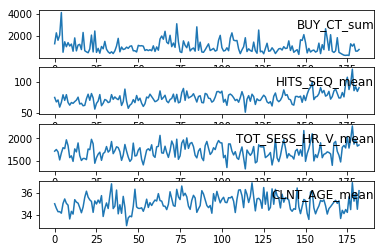

In [102]:
#Plot of all variables
values = Class1.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(Class1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

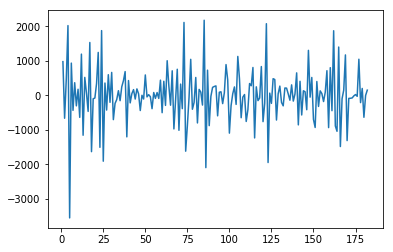

In [26]:
#with diff
Y = Class1['BUY_CT_sum']
diff = difference(Y)[1:]
pyplot.plot(diff)
pyplot.show()

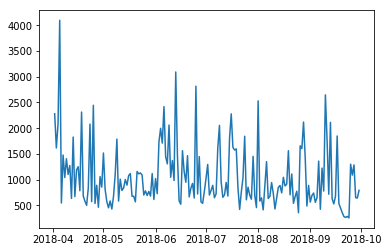

In [27]:
#without diff
pyplot.plot(Y[1:])
pyplot.show()

In [28]:
diff=difference(Y)
diff.index=Class1.index
pd.concat([Class1,diff],axis=1).head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,0
SESS_DT,,,,,
2018-04-01,1306,74.850340,1719.490868,35.022676,1306
2018-04-02,2280,67.553411,1756.592258,34.607465,974
2018-04-03,1615,70.748404,1703.317481,34.291188,-665
2018-04-04,2079,59.063566,1525.807812,34.294574,464
2018-04-05,4097,66.813036,1678.644214,34.150943,2018


In [29]:
#make dataset 'df1' with diff
diff.index=Class1.index
df1=pd.concat([Class1,diff],axis=1)

In [30]:
df1.rename(columns={0: 'diff_Y'}, inplace=True)
#remove original Y
df1=df1[['HITS_SEQ_mean', 'TOT_SESS_HR_V_mean', 'CLNT_AGE_mean','diff_Y']]
df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-01,74.850340,1719.490868,35.022676,1306
2018-04-02,67.553411,1756.592258,34.607465,974
2018-04-03,70.748404,1703.317481,34.291188,-665
2018-04-04,59.063566,1525.807812,34.294574,464
2018-04-05,66.813036,1678.644214,34.150943,2018


# ACF

C:\Users\pj903\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


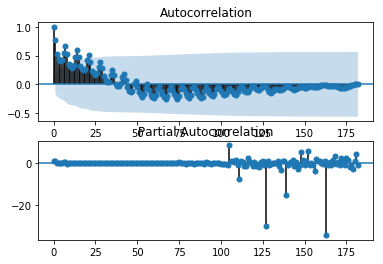

In [42]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Class4['BUY_CT_sum']
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

## Scale & prepare dataset for modeling

In [43]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm
scaled_df1=minmax(df1)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-01,0.342822,0.413383,0.509541,0.848532
2018-04-02,0.239338,0.452389,0.404708,0.790531
2018-04-03,0.284649,0.396380,0.324854,0.504193
2018-04-04,0.118936,0.209758,0.325709,0.701433
2018-04-05,0.228838,0.370440,0.289445,0.972921


In [44]:
def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm
inverse_minmax(scaled_df1,df1).head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-04-01,74.850340,1719.490868,35.022676,1306.0
2018-04-02,67.553411,1756.592258,34.607465,974.0
2018-04-03,70.748404,1703.317481,34.291188,-665.0
2018-04-04,59.063566,1525.807812,34.294574,464.0
2018-04-05,66.813036,1678.644214,34.150943,2018.0


# Modeling

In [45]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# With the Original

In [85]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [100]:
Class4.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,moving3
SESS_DT,,,,,
2018-04-01,5383,91.559754,1794.976879,34.789948,NaN
2018-04-02,5201,83.295505,1630.655263,34.775247,NaN
2018-04-03,4966,84.227786,1716.971662,34.664394,NaN
2018-04-04,4451,82.752833,1621.644756,35.009443,5183.333333
2018-04-05,3867,79.802024,1632.115778,35.206453,4872.666667


In [108]:
dataset=Class1
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.273366   0.342822   0.413383   0.509540  0.526946
2   0.526946   0.239338   0.452389   0.404708  0.353814
3   0.353814   0.284649   0.396380   0.324854  0.474616
4   0.474616   0.118936   0.209758   0.325709  1.000000
5   1.000000   0.228838   0.370440   0.289445  0.075501


In [48]:
# split into train and test sets
values = reframed.values
n_train = int(len(Class1)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(128, 1, 4) (128,) (54, 1, 4) (54,)


Train on 128 samples, validate on 54 samples
Epoch 1/50
 - 1s - loss: 0.2010 - val_loss: 0.1364
Epoch 2/50
 - 0s - loss: 0.1864 - val_loss: 0.1252
Epoch 3/50
 - 0s - loss: 0.1724 - val_loss: 0.1153
Epoch 4/50
 - 0s - loss: 0.1587 - val_loss: 0.1065
Epoch 5/50
 - 0s - loss: 0.1469 - val_loss: 0.1002
Epoch 6/50
 - 0s - loss: 0.1370 - val_loss: 0.0973
Epoch 7/50
 - 0s - loss: 0.1295 - val_loss: 0.0954
Epoch 8/50
 - 0s - loss: 0.1238 - val_loss: 0.0947
Epoch 9/50
 - 0s - loss: 0.1198 - val_loss: 0.0952
Epoch 10/50
 - 0s - loss: 0.1167 - val_loss: 0.0973
Epoch 11/50
 - 0s - loss: 0.1149 - val_loss: 0.1003
Epoch 12/50
 - 0s - loss: 0.1139 - val_loss: 0.1031
Epoch 13/50
 - 0s - loss: 0.1135 - val_loss: 0.1057
Epoch 14/50
 - 0s - loss: 0.1137 - val_loss: 0.1078
Epoch 15/50
 - 0s - loss: 0.1140 - val_loss: 0.1095
Epoch 16/50
 - 0s - loss: 0.1142 - val_loss: 0.1107
Epoch 17/50
 - 0s - loss: 0.1143 - val_loss: 0.1115
Epoch 18/50
 - 0s - loss: 0.1143 - val_loss: 0.1117
Epoch 19/50
 - 0s - loss: 0.

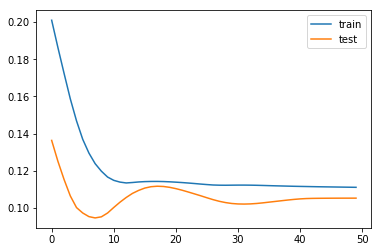

In [49]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 520.944


# With the Diff

In [59]:
df1.tail()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,diff_Y
SESS_DT,,,,
2018-09-26,121.189840,2277.464430,36.965241,-212
2018-09-27,86.075885,1875.517766,35.261383,198
2018-09-28,92.555963,1981.992661,36.036697,-637
2018-09-29,84.806452,1831.482079,34.516129,-6
2018-09-30,90.842878,1856.455882,36.226138,149


In [60]:
dataset=df1
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled=minmax(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.622094   0.904267   0.615260   0.833324  0.776362
2   0.620842   0.910633   0.615189   0.776362  0.495156
3   0.621390   0.901493   0.615135   0.495156  0.688861
4   0.619385   0.871037   0.615135   0.688861  0.955483
5   0.620715   0.897259   0.615111   0.955483  0.000000


In [61]:
# split into train and test sets
values = reframed.values
n_train = int(len(df1)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(128, 1, 4) (128,) (54, 1, 4) (54,)


Train on 128 samples, validate on 54 samples
Epoch 1/50
 - 1s - loss: 0.3921 - val_loss: 0.3686
Epoch 2/50
 - 0s - loss: 0.3698 - val_loss: 0.3437
Epoch 3/50
 - 0s - loss: 0.3447 - val_loss: 0.3191
Epoch 4/50
 - 0s - loss: 0.3205 - val_loss: 0.2954
Epoch 5/50
 - 0s - loss: 0.2971 - val_loss: 0.2726
Epoch 6/50
 - 0s - loss: 0.2747 - val_loss: 0.2509
Epoch 7/50
 - 0s - loss: 0.2533 - val_loss: 0.2302
Epoch 8/50
 - 0s - loss: 0.2328 - val_loss: 0.2104
Epoch 9/50
 - 0s - loss: 0.2134 - val_loss: 0.1915
Epoch 10/50
 - 0s - loss: 0.1949 - val_loss: 0.1738
Epoch 11/50
 - 0s - loss: 0.1775 - val_loss: 0.1569
Epoch 12/50
 - 0s - loss: 0.1610 - val_loss: 0.1412
Epoch 13/50
 - 0s - loss: 0.1456 - val_loss: 0.1265
Epoch 14/50
 - 0s - loss: 0.1312 - val_loss: 0.1128
Epoch 15/50
 - 0s - loss: 0.1178 - val_loss: 0.1000
Epoch 16/50
 - 0s - loss: 0.1054 - val_loss: 0.0883
Epoch 17/50
 - 0s - loss: 0.0939 - val_loss: 0.0775
Epoch 18/50
 - 0s - loss: 0.0834 - val_loss: 0.0676
Epoch 19/50
 - 0s - loss: 0.

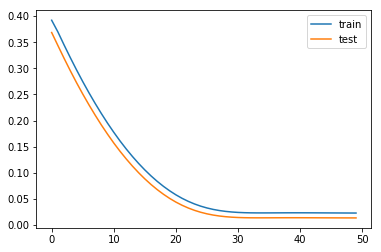

In [62]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [63]:
test_X.shape

(54, 1, 4)

In [64]:
inv_yhat

array([-243.34912  ,  -90.20508  , -107.73535  , -157.11255  ,
        -88.364746 ,  -83.56299  , -102.228516 , -105.44238  ,
        -97.01416  ,   19.346191 , -106.881836 , -115.74927  ,
         16.918701 , -273.58154  ,  -41.82202  , -235.99146  ,
        -65.65088  ,  -62.979736 , -188.00659  ,  154.74121  ,
       -125.76465  ,  100.67432  , -269.9431   , -276.12842  ,
         -3.7790527, -104.39502  ,   16.53125  , -128.21216  ,
       -141.01172  , -104.37744  ,   38.335205 , -225.58276  ,
         26.99292  , -187.55713  ,  240.2041   , -260.44702  ,
       -291.89014  ,  152.3357   , -435.7942   ,  -71.59448  ,
        -15.957031 ,  124.081055 , -357.04883  , -158.5437   ,
        -88.47534  ,  -78.94849  ,  -76.982666 ,  -15.654785 ,
        -80.862305 ,  158.41333  ,   -7.722412 ,  -20.348633 ,
       -152.96631  ,  -67.74219  ], dtype=float32)

In [65]:
inv_y

array([   44.,   266.,  -207.,  -306.,   211.,   207.,    38.,  -143.,
         302.,  -168.,    36.,   649.,  -857.,   405.,  -570.,   131.,
         103.,  -418.,  1301.,   -54.,   516.,  -699.,  -932.,   399.,
        -323.,   128.,    48.,  -181.,    89.,   712.,  -936.,   800.,
        -446.,  1869.,  -888., -1043.,  1397., -1484.,  -101.,   151.,
        1169., -1312.,   -90.,   -86.,   -77.,   -18.,    21.,   -30.,
        1044.,  -212.,   198.,  -637.,    -6.,   149.])

In [66]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
dfhat = concatenate((yhat, test_X[:, 0:3]), axis=1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,0],df1['diff_Y'])
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#df = concatenate((test_y, test_X[:, 0:3]), axis=1)
#inv_df = scaler.inverse_transform(df)
inv_y = df1.values[n_train+1:,3]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 679.088


# 변수 추가

In [ ]:
#Dataset of Class4
p1=class4['PD_BUY_CT'].groupby(class4['SESS_DT']).agg({'BUY_CT_sum': np.sum})
p2=class4['HITS_SEQ'].groupby(class4['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
p3=class4['TOT_SESS_HR_V'].groupby(class4['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
p4=class4['CLNT_AGE'].groupby(class4['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
Class4=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
mm1.shape,mm2.shape,Class4.shape

In [70]:
import pandas as pd
from pandas import DataFrame
import random

In [236]:
#이동평균선
moving3= Class4['BUY_CT_sum'].rolling(3).mean()
moving3=pd.DataFrame(moving3).shift(1)

In [237]:
Class4=pd.merge(Class4,moving3,on=['SESS_DT'])

In [238]:
weather=pd.read_csv('weather.csv')
weather.head()

,city,T,temperature,rainfall
0,Seoul,2018-04-01,15.6,0.0
1,Seoul,2018-04-02,18.4,0.0
2,Seoul,2018-04-03,17.8,0.1
3,Seoul,2018-04-04,13.4,18.5
4,Seoul,2018-04-05,7.6,10.5


In [239]:
weather=weather.loc[weather['city']=='Seoul']
weather.columns=['city','SESS_DT','Temperature','Rainfall']
weather.drop(['city'],axis=1,inplace=True)

In [240]:
weather['SESS_DT'] = pd.to_datetime(session['SESS_DT'], format="%Y%m%d")

In [241]:
Class4=pd.merge(Class4,weather,on=['SESS_DT'])

In [245]:
Class4.columns=['SESS_DT', 'BUY_CT_sum', 'HITS_SEQ_mean', 'TOT_SESS_HR_V_mean',
       'CLNT_AGE_mean', 'moving3', 'Temperature', 'Rainfall']

In [291]:
Class4.head()

,SESS_DT,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,moving3,Temperature,Rainfall
0,2018-04-03,4966,84.227786,1716.971662,34.664394,NaN,19.4,18.0
1,2018-04-04,4451,82.752833,1621.644756,35.009443,5183.333333,20.8,6.5
2,2018-04-05,3867,79.802024,1632.115778,35.206453,4872.666667,30.1,0.0
3,2018-04-08,3701,89.588137,1812.495346,35.833800,3520.000000,31.8,0.0
4,2018-04-08,3701,89.588137,1812.495346,35.833800,3520.000000,31.3,0.0


# Modeling with Class4

In [235]:
# #Dataset of Class4
# p1=class4['PD_BUY_CT'].groupby(class4['SESS_DT']).agg({'BUY_CT_sum': np.sum})
# p2=class4['HITS_SEQ'].groupby(class4['SESS_DT']).agg({'HITS_SEQ_mean': np.mean})
# p3=class4['TOT_SESS_HR_V'].groupby(class4['SESS_DT']).agg({'TOT_SESS_HR_V_mean':np.mean})
# p4=class4['CLNT_AGE'].groupby(class4['SESS_DT']).agg({'CLNT_AGE_mean':np.mean})
# mm1=pd.merge(p1,p2,on=['SESS_DT'],how='inner')
# mm2=pd.merge(mm1,p3,on=['SESS_DT'],how='inner')
# Class4=pd.merge(mm2,p4,on=['SESS_DT'],how='inner')
# mm1.shape,mm2.shape,Class4.shape

C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\Users\pj903\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


((183, 2), (183, 3), (183, 4))

C:\Users\pj903\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


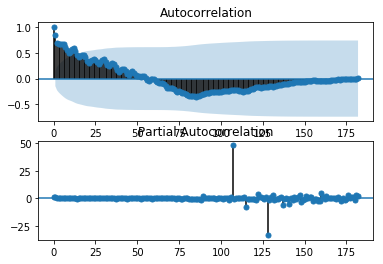

In [246]:
#ACF Plot
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Class4['BUY_CT_sum']
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

In [263]:
#diff

In [264]:
Y=Class4['BUY_CT_sum']
diff=difference(Y)
diff.index=Class4.index
df4=pd.concat([Class4,diff],axis=1)

In [266]:
df4.rename(columns={0: 'diff_Y'}, inplace=True)
#remove original Y
df4=df4[['HITS_SEQ_mean', 'TOT_SESS_HR_V_mean', 'CLNT_AGE_mean','moving3','Temperature','Rainfall','diff_Y']]
df4.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,moving3,Temperature,Rainfall,diff_Y
0,84.227786,1716.971662,34.664394,NaN,19.4,18.0,4966
1,82.752833,1621.644756,35.009443,5183.333333,20.8,6.5,-515
2,79.802024,1632.115778,35.206453,4872.666667,30.1,0.0,-584
3,89.588137,1812.495346,35.833800,3520.000000,31.8,0.0,-166
4,89.588137,1812.495346,35.833800,3520.000000,31.3,0.0,0


In [267]:
df4_=df4[1:]

In [268]:
df4_.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,moving3,Temperature,Rainfall,diff_Y
1,82.752833,1621.644756,35.009443,5183.333333,20.8,6.5,-515
2,79.802024,1632.115778,35.206453,4872.666667,30.1,0.0,-584
3,89.588137,1812.495346,35.833800,3520.000000,31.8,0.0,-166
4,89.588137,1812.495346,35.833800,3520.000000,31.3,0.0,0
5,84.174570,1653.865974,35.303311,3970.666667,23.7,0.0,246


In [287]:
#Original
Class4.iloc[:,1:]

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,moving3,Temperature,Rainfall
0,4966,84.227786,1716.971662,34.664394,NaN,19.4,18.0
1,4451,82.752833,1621.644756,35.009443,5183.333333,20.8,6.5
2,3867,79.802024,1632.115778,35.206453,4872.666667,30.1,0.0
3,3701,89.588137,1812.495346,35.833800,3520.000000,31.8,0.0
4,3701,89.588137,1812.495346,35.833800,3520.000000,31.3,0.0
5,3947,84.174570,1653.865974,35.303311,3970.666667,23.7,0.0
6,3947,84.174570,1653.865974,35.303311,3970.666667,30.9,0.0
7,3529,84.129952,1673.371497,35.321128,4052.666667,7.6,10.5
8,3529,84.129952,1673.371497,35.321128,4052.666667,23.0,0.0
9,3529,84.129952,1673.371497,35.321128,4052.666667,31.7,0.0


In [ ]:
new_order = [1,2,3,4,0]
Class4=Class4[Class4.columns[new_order]]

In [273]:
dataset=df4_
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [274]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.116092,0.200262,0.518511,1.000000,0.567114,0.067358,0.505459,0.042255,0.224008,0.611864,0.914886,0.879195,0.0,0.49247
2,0.042255,0.224008,0.611864,0.914886,0.879195,0.000000,0.492470,0.287129,0.633058,0.909121,0.544292,0.936242,0.0,0.57116
3,0.287129,0.633058,0.909121,0.544292,0.936242,0.000000,0.571160,0.287129,0.633058,0.909121,0.544292,0.919463,0.0,0.60241
4,0.287129,0.633058,0.909121,0.544292,0.919463,0.000000,0.602410,0.151667,0.273331,0.657757,0.667763,0.664430,0.0,0.64872
5,0.151667,0.273331,0.657757,0.667763,0.664430,0.000000,0.648720,0.151667,0.273331,0.657757,0.667763,0.906040,0.0,0.60241


In [275]:
dataset=df4_
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11,12]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.116092   0.200262   0.518511   1.000000   0.567114   0.067358   
2   0.042255   0.224008   0.611864   0.914886   0.879195   0.000000   
3   0.287129   0.633058   0.909121   0.544292   0.936242   0.000000   
4   0.287129   0.633058   0.909121   0.544292   0.919463   0.000000   
5   0.151667   0.273331   0.657757   0.667763   0.664430   0.000000   

   var7(t-1)  var7(t)  
1   0.505459  0.49247  
2   0.492470  0.57116  
3   0.571160  0.60241  
4   0.602410  0.64872  
5   0.648720  0.60241  


In [277]:
# split into train and test sets
values = reframed.values
n_train = int(len(df1)*0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(128, 1, 13) (128,) (53, 1, 13) (53,)


Train on 128 samples, validate on 53 samples
Epoch 1/50
 - 3s - loss: 0.1157 - val_loss: 0.0962
Epoch 2/50
 - 0s - loss: 0.0910 - val_loss: 0.0747
Epoch 3/50
 - 0s - loss: 0.0697 - val_loss: 0.0553
Epoch 4/50
 - 0s - loss: 0.0512 - val_loss: 0.0391
Epoch 5/50
 - 0s - loss: 0.0363 - val_loss: 0.0261
Epoch 6/50
 - 0s - loss: 0.0246 - val_loss: 0.0161
Epoch 7/50
 - 0s - loss: 0.0162 - val_loss: 0.0091
Epoch 8/50
 - 0s - loss: 0.0108 - val_loss: 0.0046
Epoch 9/50
 - 0s - loss: 0.0081 - val_loss: 0.0024
Epoch 10/50
 - 0s - loss: 0.0073 - val_loss: 0.0017
Epoch 11/50
 - 0s - loss: 0.0079 - val_loss: 0.0019
Epoch 12/50
 - 0s - loss: 0.0092 - val_loss: 0.0025
Epoch 13/50
 - 0s - loss: 0.0104 - val_loss: 0.0030
Epoch 14/50
 - 0s - loss: 0.0112 - val_loss: 0.0031
Epoch 15/50
 - 0s - loss: 0.0113 - val_loss: 0.0029
Epoch 16/50
 - 0s - loss: 0.0109 - val_loss: 0.0025
Epoch 17/50
 - 0s - loss: 0.0101 - val_loss: 0.0021
Epoch 18/50
 - 0s - loss: 0.0092 - val_loss: 0.0018
Epoch 19/50
 - 0s - loss: 0.

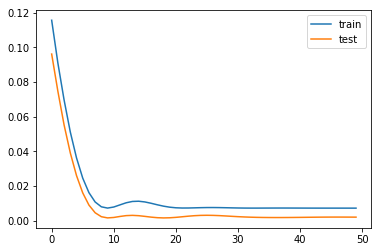

In [278]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [279]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
dfhat = concatenate((yhat, test_X[:, 0:3]), axis=1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,0],df4_['diff_Y'])
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#df = concatenate((test_y, test_X[:, 0:3]), axis=1)
#inv_df = scaler.inverse_transform(df)
inv_y = df4_.values[n_train+1:,3]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3737.010


In [289]:
df4_.values[n_train+1:,:]

array([[ 9.36186147e+01,  1.67431369e+03,  3.48181818e+01,
         2.65833333e+03,  1.73000000e+01,  6.50000000e+00,
         0.00000000e+00],
       [ 9.36186147e+01,  1.67431369e+03,  3.48181818e+01,
         2.65833333e+03,  3.11000000e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 9.36186147e+01,  1.67431369e+03,  3.48181818e+01,
         2.65833333e+03,  1.90000000e+01,  5.00000000e+00,
         0.00000000e+00],
       [ 9.86830743e+01,  1.73100649e+03,  3.51683938e+01,
         2.67566667e+03,  1.40000000e+01,  0.00000000e+00,
        -2.10000000e+01],
       [ 9.86830743e+01,  1.73100649e+03,  3.51683938e+01,
         2.67566667e+03,  1.63000000e+01,  6.50000000e+00,
         0.00000000e+00],
       [ 9.86830743e+01,  1.73100649e+03,  3.51683938e+01,
         2.67566667e+03,  2.33000000e+01,  2.00000000e-01,
         0.00000000e+00],
       [ 1.05531031e+02,  1.83114672e+03,  3.52563411e+01,
         2.28200000e+03,  1.41000000e+01,  0.00000000e+00,
        -4.7000000

In [290]:
df4_.values

array([[  82.75283286, 1621.64475558,   35.00944287, ...,   20.8       ,
           6.5       , -515.        ],
       [  79.80202352, 1632.11577784,   35.20645338, ...,   30.1       ,
           0.        , -584.        ],
       [  89.58813654, 1812.49534556,   35.83379966, ...,   31.8       ,
           0.        , -166.        ],
       ...,
       [ 103.88949742, 1692.24967742,   34.49420103, ...,   16.1       ,
           0.        ,  561.        ],
       [ 106.08185841, 1757.53116102,   34.88938053, ...,   22.7       ,
          19.5       , -405.        ],
       [ 112.41407272, 1807.24397906,   34.72403871, ...,   13.3       ,
           0.        ,  731.        ]])